- Facial Recognition with Keras, Dlib and OpenCV
- this project the approach of this [paper](https://arxiv.org/abs/1503.03832)

### Import Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import bz2 # used to compress data for storage or transmission.
import os
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer
from sklearn.metrics import f1_score, accuracy_score

import numpy as np
import os.path
from urllib.request import urlopen # to open and download from url
from align import AlignDlib

%matplotlib inline

Using TensorFlow backend.


ModuleNotFoundError: No module named 'dlib'

### Download Face_landmarks pretrained model

In [0]:
def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(landmarks_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

In [0]:
landmarks_dir = 'models'
landmarks_file = os.path.join(landmarks_dir, 'landmarks.dat')

if not os.path.exists(landmarks_file):
    os.makedirs(landmarks_dir)
    download_landmarks(landmarks_file)

- Instead of training the model from scratch, I use transfer learning concept using this pretrained [weights](https://cmusatyalab.github.io/openface/models-and-accuracies/#model-definitions)
- This notebook uses a Keras implementation of that model whose definition was taken from the [Keras-OpenFace project](https://github.com/iwantooxxoox/Keras-OpenFace). The architecture details aren't too important here, it's only useful to know that there is a fully connected layer with 128 hidden units followed by an L2 normalization layer on top of the convolutional base. These two top layers are referred to as the embedding layer from which the 128-dimensional embedding vectors can be obtained.

In [0]:
from model import create_model
nn4_small2 = create_model()

Instructions for updating:
Colocations handled automatically by placer.


### Triplet loss Function

triplet loss function
$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

In [0]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss


### Loading pretrained weights to our model

he OpenFace project provides [pre-trained models](https://cmusatyalab.github.io/openface/models-and-accuracies/#pre-trained-models) that were trained with the public face recognition datasets [FaceScrub](http://vintage.winklerbros.net/facescrub.html) and [CASIA-WebFace](http://arxiv.org/abs/1411.7923). The Keras-OpenFace project converted the weights of the pre-trained nn4.small2.v1 model to [CSV files](https://github.com/iwantooxxoox/Keras-OpenFace/tree/master/weights) which were then converted to a binary format that can be loaded by Keras with `load_weights`:

In [0]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

The nn4.small2.v1 model was trained with aligned face images, therefore, the face images from the custom dataset must be aligned too. Here, we use [Dlib](http://dlib.net/) for face detection and [OpenCV](https://opencv.org/) for image transformation and cropping to produce aligned 96x96 RGB face images. 

In [0]:
# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

### Loading Database

In [0]:
class IdentityDatabase():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 

In [0]:
def load_database(path):
    database = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                database.append(IdentityDatabase(path, i, f))
    return np.array(database)

In [0]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

As described in the OpenFace pre-trained models section, landmark indices OUTER_EYES_AND_NOSE are required for model nn4.small2.v1. Let's implement face detection, transformation and cropping as align_image function for later reuse.

In [0]:
# face alignment
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

Embedding vectors can now be calculated by feeding the aligned and scaled images into the pre-trained network.

In [0]:
def update_db():
    database = load_database('Database')
    
    embedded_database = np.zeros((database.shape[0], 128))

    for i, m in enumerate(database):
        img = load_image(m.image_path())
        img = align_image(img)
        # scale RGB values to interval [0,1] # Normalization step
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image > forward propagation step
        embedded_database[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    return database, alignment, embedded_database

In [0]:
database, alignment, embedded_database = update_db()

### Face Alignment Step
- **Face alignment** is a computer vision technology for identifying the geometric structure of human faces in digital images. Given the location and size of a face, it automatically determines the shape of the face components such as eyes and nose.

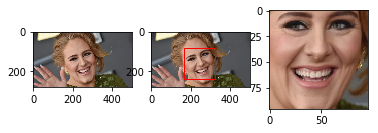

In [0]:
# Load an image of Jacques Chirac
jc_orig = load_image(database[4].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

### Calculate the Similarity between two embedding images

In [0]:
# calculate the distance between 2 embedding vectors
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

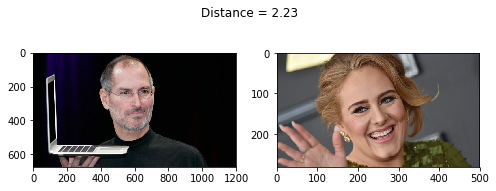

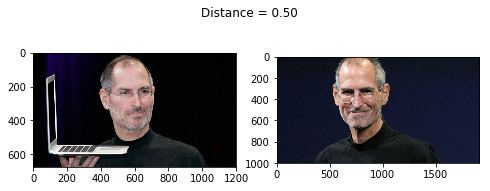

In [0]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded_database[idx1], embedded_database[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(database[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(database[idx2].image_path()));    

show_pair(6, 4) # for the same person
show_pair(6, 7) # for different person

### Testing our model

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import warnings
import os
import shutil
warnings.filterwarnings('ignore')

In [0]:
def test(img_path):
    test_image = img_path
    test_image = cv2.imread(test_image)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    image = align_image(test_image)
    image = (image / 255.).astype(np.float32)

    embedded_test = nn4_small2_pretrained.predict(np.expand_dims(image, axis=0))[0]
    example_prediction = svc.predict([embedded_test])
    example_identity = db_encoder.inverse_transform(example_prediction)[0]
    dis = min_distance(embedded_test)
  
    if dis > 0.7:
        print('This image not found in the database. It will be add.')
        imageName = input("Enter the person's name: ")
    
        directory = 'Database/' + imageName + '/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        shutil.move(img_path, directory)
        return
  
    plt.imshow(test_image)
    plt.title(f'Recognized as {example_identity}');
  

In [0]:
def min_distance(embedded_test):
    minDis = []
    for i in range(len(embedded_database)):
        dis = distance(embedded_database[i], embedded_test)
        minDis.append(dis)
    return min(minDis)
    

#### Run the Folowing 2 cells every time you update the database

In [0]:
# updating the database if you add more images
database, alignment, embedded_database = update_db()

In [0]:
db_targets = np.array([m.name for m in database])

db_encoder = LabelEncoder()
db_encoder.fit(db_targets)

# Numerical encoding of identities
y_db = db_encoder.transform(db_targets)
db_idx = np.arange(database.shape[0]) 
X_db = embedded_database[db_idx]
svc = LinearSVC()
svc.fit(X_db, y_db)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

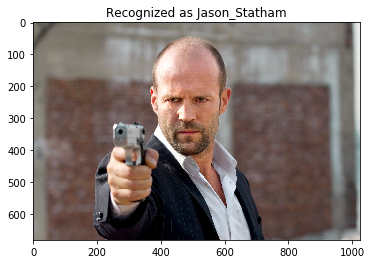

In [0]:
test('test1.jpg')

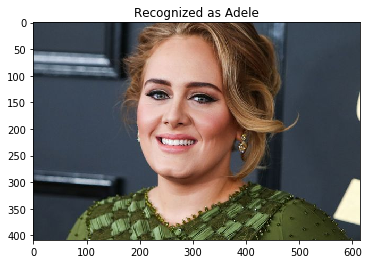

In [0]:
test('test2.jpg')

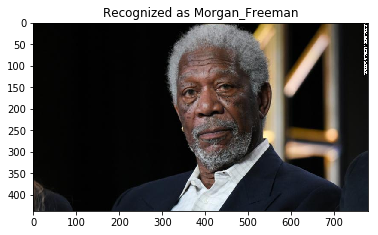

In [0]:
test('test3.jpg')

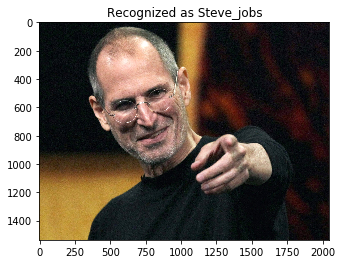

In [0]:
test('test4.jpg')

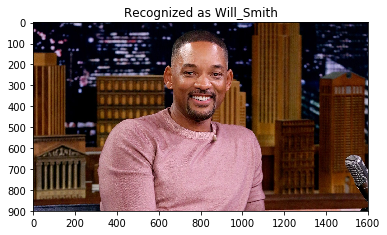

In [0]:
test('test5.jpg')

In [0]:
test('test6.jpg')

This image not found in the database. It will be add.
Enter the person's name: Tom_Cruise


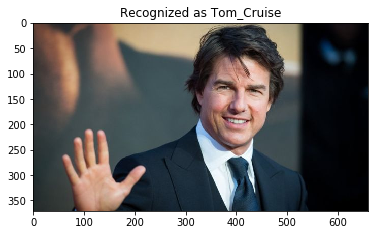

In [0]:
test('test7.jpg')